In [1]:
import torchaudio
import torchaudio.functional as F_audio
import torchaudio.transforms as T_audio

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import Tensor
from torchdata.datapipes.iter import FileOpener, HttpReader, IterableWrapper
from torch.utils.data import DataLoader
import functools
import os
import librosa
import numpy as np

import warnings
import glob
import io
from joblib import delayed 
import fma.utils as fma

from cacher import root, file_cached, mem_cached, clear_cache
from utils import ProgressParallel, plot_waveform, plot_spectrogram, plot_fbank, plot_mel_fbank
from data_loader import read_wavs

from IPython.display import Audio, display

from spectrogrammer import Spectrogramer
import matplotlib.pyplot as plt

SAMPLE_RATE = 4096
LENGTH_SECONDS = 5.0
LENGTH = int(round((LENGTH_SECONDS * SAMPLE_RATE)))
wavs = read_wavs("small", SAMPLE_RATE, LENGTH_SECONDS, LENGTH)
wavs = Tensor(wavs)
print("wavs.shape=", wavs.shape)

N_FFT = 1024
WIN_LENGTH = None
HOP_LENGTH = 512
N_MELS = 128
spectrogrammer = Spectrogramer(sample_rate = SAMPLE_RATE,
              n_fft = N_FFT,
              win_length = WIN_LENGTH,
              hop_length = HOP_LENGTH,
              n_mels = N_MELS)
x = spectrogrammer.wave2mel(wavs)
print("x (spectrogram of wavs).shape=", x.shape)

wavs.shape= torch.Size([7994, 20480])
x (spectrogram of wavs).shape= torch.Size([7994, 128, 41])


In [43]:
x.shape[-2]

128

[0/5000] [0.0 s]	 loss: 187.7825 loss_test: 1255.6469  lr: 0.0700  accurancy: 31.7759 samples_count: 50.0000 
[1/5000] [0.0 s]	 loss: 1170.0870 loss_test: 186.8750  lr: 0.0700  accurancy: 11.3034 samples_count: 50.0000 
[2/5000] [0.1 s]	 loss: 185.6770 loss_test: 267.3479  lr: 0.0700  accurancy: 13.5236 samples_count: 50.0000 
[3/5000] [0.1 s]	 loss: 269.4381 loss_test: 113.7128  lr: 0.0700  accurancy: 8.7332 samples_count: 50.0000 
[4/5000] [0.1 s]	 loss: 105.0437 loss_test: 94.8006  lr: 0.0700  accurancy: 7.8241 samples_count: 50.0000 
[5/5000] [0.1 s]	 loss: 92.1029 loss_test: 54.3143  lr: 0.0700  accurancy: 5.6172 samples_count: 50.0000 
[6/5000] [0.1 s]	 loss: 54.5585 loss_test: 27.9183  lr: 0.0700  accurancy: 4.3128 samples_count: 50.0000 
[7/5000] [0.2 s]	 loss: 27.2901 loss_test: 17.5777  lr: 0.0700  accurancy: 3.4084 samples_count: 50.0000 
[8/5000] [0.2 s]	 loss: 17.2284 loss_test: 10.7762  lr: 0.0700  accurancy: 2.4747 samples_count: 50.0000 
[9/5000] [0.2 s]	 loss: 10.3899 

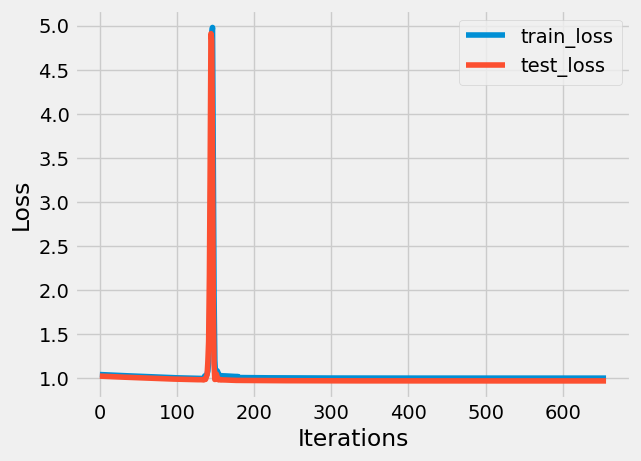

In [52]:
# nn.Tanhshrink(),
# nn.Sigmoid(),
# nn.ReLU(),

import importlib
import trainer_mod
import tuner

importlib.reload(trainer_mod)
importlib.reload(tuner)
Trainer = trainer_mod.Trainer

def remap(val, old_0, old_1, new_0, new_1):
    return (val - old_0) / (old_1 - old_0) * (new_1 - new_0) + new_0

def suggest_activation(name, trial):
    cat = trial.suggest_categorical(name, ["tanh", "relu", "leakyrelu", "sigmoid"])
    if cat == "tanh":
        return nn.Tanh()
    elif cat == "relu":
        return nn.ReLU(True)
    elif cat == "leakyrelu":
        return nn.LeakyReLU(trial.suggest_float("leakyrelu",0.01, 0.01, 0.1, log=True))
    elif cat == "sigmoid":
        return nn.Sigmoid() 


class LogShape(nn.Module):
    def __init__(self):
        super(LogShape, self).__init__()

    def forward(self, x):
        print(x.shape)
        return x

class CutPadding(nn.Module):
    def __init__(self, padding):
        super(CutPadding, self).__init__()
        self.padding = torch.Size(padding)

    def forward(self, x):
        shape = x.shape
        return x[:, :, :shape[-2] - self.padding[0], :shape[-1] - self.padding[1]]

class Autoencoder(nn.Module):
    def __init__(self, max_val, trial):
        super().__init__()

        self.max_val = max_val

        mk = trial.suggest_int("mid_kernels", 2, 2, 10)

        if trial.suggest_int("batchnorm", 1, 0, 1) == 1:
            batch_normalization = lambda channels: nn.BatchNorm2d(channels)
        else:
            batch_normalization = lambda channels: nn.Identity()
        
        self.encoder = nn.Sequential( # 1, 128, 41
            nn.Conv2d(1, mk, kernel_size=(8, 9), padding="same"),  # mk, 128, 41
            batch_normalization(mk),
            suggest_activation("act_enc1", trial),

            nn.Conv2d(mk, mk, kernel_size=(8, 9), padding="same"),  # mk, 128, 41
            batch_normalization(mk),
            suggest_activation("act_enc2", trial),

            nn.MaxPool2d(kernel_size=(1, 3), padding=(0, 1)),  # mk, 128, 14

            nn.Conv2d(mk, mk, kernel_size=(8, 9), padding="same"),  # mk, 128, 41
            batch_normalization(mk),
            suggest_activation("act_enc3", trial),

            nn.Conv2d(mk, 1, kernel_size=(8, 9), padding="same"),  # mk, 128, 41
            batch_normalization(1),
            suggest_activation("act_enc4", trial),

            # nn.Conv2d(mk, 2, kernel_size=(8, 3), padding="same"), # mk, 128, 9
            # batch_normalization(2),
            # suggest_activation("act_enc2", trial),
            # nn.MaxPool2d(kernel_size=(1, 3)),  # mk, 128, 1

            # nn.Conv2d(mk, 4, kernel_size=(4, 3), padding="same"), # 4, 16, 9
            # batch_normalization(4),
            # suggest_activation("act_enc3", trial),
            # nn.MaxPool2d(kernel_size=(1, 3)),  # 4, 16, 3
            
            # nn.Flatten(),
            # nn.Linear(1*128*14, 1*128*14),
            # nn.BatchNorm1d(1*128*14),
            # nn.Tanh(),
            # nn.Unflatten(1, (1,128,14))
        )

        self.decoder = nn.Sequential(
            # nn.Conv2d(4, mk, kernel_size=(4, 3), padding="same"), # mk, 8, 9
            # suggest_activation("act_dec1", trial),
            # batch_normalization(mk),
            # nn.UpsamplingNearest2d(scale_factor=(1, 3)),  # mk, 16, 9

            # nn.Conv2d(mk, mk, kernel_size=(4, 3), padding="same"), # mk, 16, 9
            # suggest_activation("act_dec2", trial),
            # batch_normalization(mk),
            # nn.UpsamplingNearest2d(scale_factor=(1, 3)),  # mk, 32, 9

            nn.Conv2d(1, mk, kernel_size=(8, 4), padding="same"), # mk, 32, 9
            batch_normalization(mk),
            suggest_activation("act_dec3", trial),

            nn.Conv2d(mk, mk, kernel_size=(8, 4), padding="same"), # mk, 32, 9
            batch_normalization(mk),
            suggest_activation("act_dec4", trial),

            nn.UpsamplingNearest2d(scale_factor=(1, 3)),  # mk, 128, 9
            CutPadding((0, 1)),

            nn.Conv2d(mk, 1, kernel_size=(16, 3), padding="same"), # 1, 128, 9
            suggest_activation("act_dec5", trial),
        )

    def forward(self, x):
        encoded = self.encoder(x / self.max_val)
        decoded = self.decoder(encoded)
        return decoded * self.max_val

def accurancy(trainer):
    real = trainer.x_test
    with torch.no_grad():
        predicted = trainer.model(real)

    accurancy = ((real - predicted).abs()).mean().item() 

    return {
        "accurancy": accurancy,
    }

def calc_loss_on_data(model, loss, x_gt):
    x_pred = model(x_gt)
    return loss(x_gt, x_pred)


def create_trainer(trial, x):
    max_val = x.max().item()
    model = Autoencoder(max_val, trial)

    optimizer = torch.optim.Adam(model.parameters(), 
                            lr=trial.suggest_float("lr", 7e-2, 1e-3, 1e-1, log=True), 
                            betas=(0.5, 0.999))
    trainer = Trainer(model=model, 
                    loss=nn.MSELoss(),
                    optimizer=optimizer,
                    scheduler=ReduceLROnPlateau(optimizer, factor=0.7, threshold=1e-2, patience=50),
                    sampler=trainer_mod.PreheatSampler(initial_count=50, grow_amount=100, patience=1),
                    # sampler=trainer_mod.PreheatSamplerPerTime(initial_count=100, grow_amount=100),
                    calc_loss_on_data=calc_loss_on_data,
                    additional_losses={
                        "accurancy": accurancy,
                        "samples": lambda trainer: { "samples_count": trainer.sampler.samples_count},
                    })

    x_prepared = torch.unsqueeze(x, 1) # Add channel
    trainer.set_data(x_prepared, test_count=50)

    # trainer.data_lambda = get_noised
    # early_stopping = trainer_mod.EarlyStopping(patience=25)
    early_stopping = trainer_mod.EarlyStoppingPerTime(patience=30)
    def early_stop(trainer, test_loss, time_passed, log):
        if trainer.get_lr() < 1e-5:
            if log: print("stopping by lr")
            return True
        if early_stopping.need_stop(test_loss, time_passed):
            if log: print("stopping by early stopping", test_loss, "last best", early_stopping.best_loss, "at", early_stopping.ticks_since_best_loss)
            return True
        return False

    trainer.early_stop_lambda = early_stop
    return trainer


def objective(trial):
    trainer = create_trainer(trial, x_train)
    trainer.train(100, trial=trial, log=False)
    # trainer.plot_history(100)

    return trainer.history['test_loss'][-1]

x_train = x

# cuda = torch.device('cuda:0')
# tuned_params = tuner.tune(objective, n_trials=1000, timeout=60000)
# tuned_params

# trial = tuned_params
# trial.params['lr'] = 0.01

# trial.params['batchnorm'] = 0
# trainer = create_trainer(trial, x_train) 

trial = tuner.TunedParams({"batchnorm": 1, "mid_kernels": 1})
trainer = create_trainer(trial, x_train) 
trainer.scheduler = ReduceLROnPlateau(trainer.optimizer, factor=0.7, threshold=1e-3, patience=20)
trainer.train(5000, trial=trial, log=True)
trainer.plot_history(100)


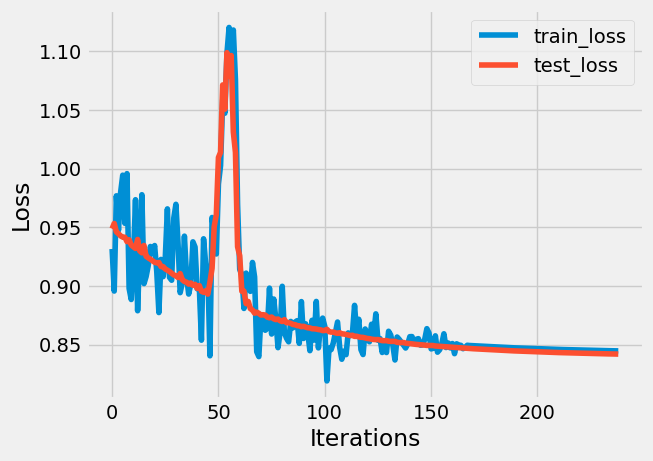

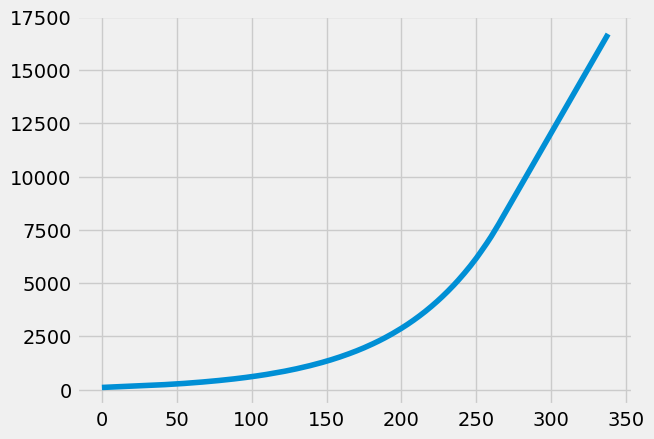

In [49]:
trainer.plot_history(100)
plt.show()
plt.plot(trainer.history['samples.samples_count'])

In [ ]:
tuned_params.__dict__

In [ ]:
# trial = tuned_params
# trial = tuned_params
trainer = create_trainer(trial) 

trainer.scheduler = ReduceLROnPlateau(trainer.optimizer, factor=0.2, threshold=1e-2, patience=25)

trainer.train(1000, trial=trial, log=True)

trainer.plot_history(100)

In [ ]:

with torch.no_grad():
    cleaned = trainer.model(noised)

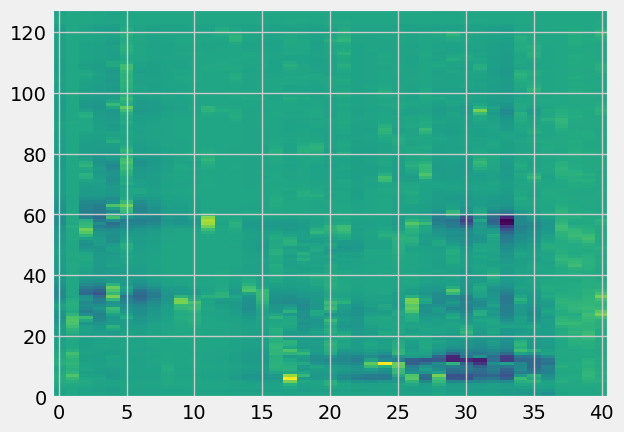

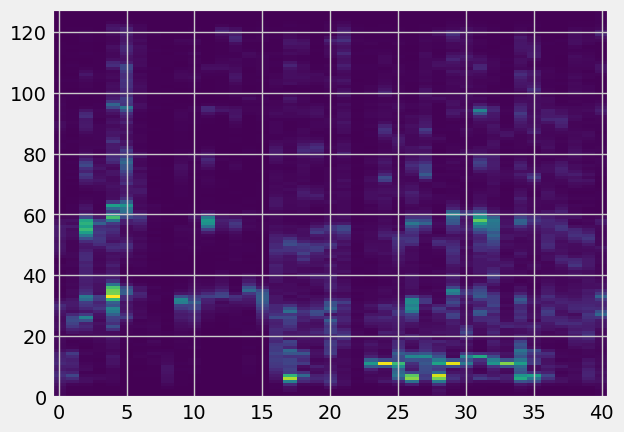

In [28]:
a = 301
x_prepared = x.cuda()[a:a + 1,].unsqueeze(1)
with torch.no_grad():
    x_predicted = trainer.model(x_prepared)

orig_wave = spectrogrammer.mel2wave_with_phase(x_prepared[0].cpu(), wavs[a])
predicted_wave = spectrogrammer.mel2wave_with_phase(x_predicted[0].cpu(), wavs[a])

# orig_wave = spectrogrammer.mel2wave(x_prepared[0].cpu())
# predicted_wave = spectrogrammer.mel2wave(x_predicted[0].cpu())


display(Audio(wavs[a], rate=SAMPLE_RATE))
display(Audio(orig_wave.numpy(), rate=SAMPLE_RATE))
display(Audio(predicted_wave.numpy(), rate=SAMPLE_RATE))
plt.imshow((x_prepared[0][0] - x_predicted[0][0]).cpu(), origin="lower", aspect="auto") #, cmap="Greys")
plt.show()
plt.imshow((x_prepared[0][0]).cpu(), origin="lower", aspect="auto") #, cmap="Greys")

In [ ]:
(x_initial_gpu[0][0] - noised[0][0]).cpu()[:,4]

In [ ]:
noised.shape

In [ ]:
# centers = torch.rand((x.shape[0], ), device=x.device)
# centers = remap(centers, 0, 1, 32, N_MELS - 32)
filters = nd_based_filter(N_MELS, centers) # (N, N_MELS)
down_filters = 1 - 0.45 * filters
# return x * down_filters[:, None, :, None]
plt.plot(down_filters[0])
plt.show()

xx = x.unsqueeze(1)
noised = xx * down_filters[:, None, :, None]
plt.imshow(noised[0][0] - xx[0][0], origin="lower", aspect="auto")

In [ ]:
x.unsqueeze(1).shape

In [ ]:
down_filters[:, None, :, None]

In [ ]:
trainer.model.filter_coef

In [ ]:
trial = tuned_params
trainer = create_trainer(trial) 
# trainer.scheduler=ReduceLROnPlateau(optimizerG, factor=0.2, threshold=1e-2, patience=50))

trainer.train(1000, trial=trial, log=True)

trainer.plot_history(100)

In [ ]:
tuned_params.suggest_int("batchnorm", 1, 0, 1)

In [ ]:
with torch.no_grad():
    x_pred = model(x_gpu)
x_pred = torch.squeeze(x_pred, dim=1)
print(x_pred.shape)
wave_pred = spectrogrammer.mel2wave_with_phase(x_pred[0], wavs[0])
display(Audio(wave_pred.cpu().numpy(), rate=SAMPLE_RATE))

In [ ]:
Audio(wavs[0].cpu().numpy() - wave_pred.cpu().numpy(), rate=SAMPLE_RATE)

In [ ]:
plot_spectrogram(x_pred[0].cpu().numpy())

In [ ]:
plot_spectrogram(x[0].cpu().numpy())

In [ ]:
display(Audio(wavs[0], rate=SAMPLE_RATE))
wave = spectrogrammer.mel2wave(x[0])
display(Audio(wave.numpy(), rate=SAMPLE_RATE))

In [ ]:
model = model_gpu.to("cpu")
x_pred = model(x)
wave_pred = spectrogrammer.mel2wave(x_pred)
wave_pred.shape

In [ ]:
spectrogrammer.mel2wave(x).shape

In [ ]:
tensor

In [ ]:
torch.__version__

In [ ]:
for epoch in range(epochs):
    for i in x:
       
    #   # Reshaping the image to (-1, 784)
    #   image = image.reshape(-1, 28*28)
       
      # Output of Autoencoder
      reconstructed = model(x)
       
      # Calculating the loss function
      loss = loss_function(reconstructed, x)
       
      # The gradients are set to zero,
      # the gradient is computed and stored.
      # .step() performs parameter update
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
       
      # Storing the losses in a list for plotting
      losses.append(loss)
      print(loss)
    outputs.append((epochs, image, reconstructed))